# Análisis exploratorio de avisos laborales y postulaciones

1. [Lectura de datos](#1. Lectura de datos)

    - [1.1. Datos sobre los postulantes](#1.1. Datos sobre los postulantes)
    - [1.2. Datos sobre los avisos](#1.2. Datos sobre los avisos)
    - [1.3. Datos sobre las transacciones](#1.3. Datos sobre las transacciones)
    
    
2. [Análisis de los postulantes](#2. Análisis de los postulantes)
    - Sexo de los postulantes
    - Cantidad de postulantes por nivel de educación alcanzado y sexo
    - Cantidad de postulantes por nivel de educación y rango de edad
3. [Análisis de los avisos](#3. Análisis de los avisos)
    - Zonas de CABA con más avisos
    - Áreas de trabajo más populares por zona
    - Ver si hay correlación con ubicación de estaciones de subte, hospitales y facultades
    - Análisis de las descripciones:
    - Rango de edad, nacionalidad, proactividad, estudiantes, residencia en la zona, Office, horarios rotativos/flexibles, PYME
4. [Análisis de las postulaciones](#4. Análisis de las postulaciones)
    - Cantidad de postulaciones por día
    - Rangos horarios con más vistas
    - Rangos horarios con más postulaciones
    - Correlación entre edad, tipo de trabajo, y horario de vistas y de postulaciones
    - Cantidad de vistas de los postulantes antes de cada postulación
    - Variedad de las áreas de trabajo a las que se postulan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime 

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (20,10)

## 1. Lectura de datos

Contamos con seis conjuntos de datos que los leemos en sus respectivos *data frames* utilizando Pandas:

In [2]:
# Postulantes
postulantes_educacion = pd.read_csv('./data/fiuba_1_postulantes_educacion.csv', low_memory=False)
postulantes_sexo_y_edad = pd.read_csv('./data/fiuba_2_postulantes_genero_y_edad.csv', low_memory=False)
# Avisos
avisos_online = pd.read_csv('./data/fiuba_5_avisos_online.csv', low_memory=False)
avisos_detalle = pd.read_csv('./data/fiuba_6_avisos_detalle.csv', low_memory=False)
# Transacciones
vistas = pd.read_csv('./data/fiuba_3_vistas.csv', low_memory=False)
postulaciones = pd.read_csv('./data/fiuba_4_postulaciones.csv', low_memory=False)

### 1.1. Datos sobre los postulantes

Tenemos dos *data frames* acerca de los postulantes: uno con información acerca de su sexo y fecha de nacimiento y el otro acerca de su nivel de educación.

In [3]:
postulantes_sexo_y_edad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200888 entries, 0 to 200887
Data columns (total 3 columns):
idpostulante       200888 non-null object
fechanacimiento    196138 non-null object
sexo               200888 non-null object
dtypes: object(3)
memory usage: 4.6+ MB


Pasamos la columna **fechanacimiento** al formato *datetime*:

In [4]:
postulantes_sexo_y_edad['fechanacimiento'] = \
    pd.to_datetime(postulantes_sexo_y_edad['fechanacimiento'], errors='coerce')

El *data frame* **postulantes_sexo_y_edad** tiene un total de 200888 registros con tres columnas:
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante
* **fechanacimiento**: año, mes y día de nacimiento del postulante separado por guiones.
* **sexo**: atributo categórico que puede tomar tres valores posibles: *FEM*, *MASC* y *NO_DECLARA*

In [5]:
postulantes_educacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298231 entries, 0 to 298230
Data columns (total 3 columns):
idpostulante    298231 non-null object
nombre          298231 non-null object
estado          298231 non-null object
dtypes: object(3)
memory usage: 6.8+ MB


El *data frame* **postulantes_educacion** tiene un total de 298231 registros con tres columnas:
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante.
* **nombre**: atributo categórico que puede tomar los siguientes valores: *Secundario*, *Terciario/Técnico*, *Universitario*, *Posgrado*, *Master*, *Doctorado* y *Otro*.
* **estado**: atributo categórico que puede tomar tres valores posibles: *En Curso*, *Graduado* y *Abandonado*

### 1.2. Datos sobre los avisos

Tenemos dos *data frames* acerca de los avisos: uno con un listado de los que se encuentraban publicados online el 8 de marzo de 2018 y otro con la información detallada de cada aviso.

In [6]:
avisos_online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 1 columns):
idaviso    5028 non-null int64
dtypes: int64(1)
memory usage: 39.4 KB


El *data frame* **avisos_online** tiene un total de 5028 registros con una sola columna:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso.

In [7]:
avisos_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13534 entries, 0 to 13533
Data columns (total 11 columns):
idaviso                 13534 non-null int64
idpais                  13534 non-null int64
titulo                  13534 non-null object
descripcion             13534 non-null object
nombre_zona             13534 non-null object
ciudad                  47 non-null object
mapacalle               872 non-null object
tipo_de_trabajo         13534 non-null object
nivel_laboral           13534 non-null object
nombre_area             13534 non-null object
denominacion_empresa    13529 non-null object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


El *data frame* **avisos_detalle** tiene un total de 13534  registros con once columnas:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso.
* **idpais**: número entero que representa el código de identificación del país del aviso.
* **titulo**: cadena de caracteres con el nombre del puesto de trabajo.
* **descripcion**: texto de varias líneas con la descripción del aviso en formato HTML.
* **nombre_zona**: cadena de caracteres que puede tener los siguientes valores: *Gran Buenos Aires*, *Capital Federal*, *GBA Oeste* y *Buenos Aires (fuera de GBA)*
* **ciudad**: cadena de caracteres con el nombre de la ciudad del puesto de trabajo.
* **mapacalle**: cadena de caracteres con la dirección del lugar de trabajo.
* **tipo_de_trabajo**: atributo categórico que puede adoptar los siguientes valores: *Full-time*, *Part-time*, *Teletrabajo*, Pasantía*, *Por Horas*, *Temporario*, *Por Contrato*, *Fines de Semana* y *Primer empleo*.
* **nivel_laboral**: atributo categórico que puede adoptar los siguientes valores: *Senior / Semi-Senior*, *Junior*, *Jefe / Supervisor / Responsable*, *Gerencia / Alta Gerencia / Dirección* y *Otro*.
* **nombre_area**: cadena de caracteres que representa el área de trabajo, como por ejemplo: *Ventas*, *Contabilidad* o *Recursos Humanos*.
* **denominacion_empresa**: nombre de la empresa que publicó el aviso.

### 1.3 Datos sobre las transacciones

Tenemos dos *data frames* con información de dos hechos a partir de las dimensiones anteriores. El *data frame* vistas contiene el detalle de todas las veces que los postulantes visualizaron los diversos avisos y el *data frame* postulaciones registra quiénes se postularon a qué avisos y cuándo.

In [8]:
vistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961897 entries, 0 to 961896
Data columns (total 3 columns):
idAviso         961897 non-null int64
timestamp       961897 non-null object
idpostulante    961897 non-null object
dtypes: int64(1), object(2)
memory usage: 22.0+ MB


El *data frame* **vistas** tiene un total de 961897 registros con tres columnas:
* **idAviso**: cadena de caracteres que representa el código de identificación del aviso visto.
* **timestamp**: año, mes día y hora exacta en la que se produjo la vista del aviso.
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante que vio el aviso.

In [9]:
postulaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
dtypes: int64(1), object(2)
memory usage: 77.9+ MB


El *data frame* **postulaciones** tiene un total de 3401623 registros con tres columnas:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso al cual se realizó la postulación.
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante.
* **fechapostulacion**: año, mes día y hora exacta en la que se produjo la postulación.

Pasamos ls columnas de fechas al formato *datetime*:

In [10]:
vistas['timestamp'] = pd.to_datetime(vistas['timestamp'], errors='coerce')
postulaciones['fechapostulacion'] = \
    pd.to_datetime(postulaciones['fechapostulacion'], errors='coerce')

## 2. Análisis de los postulantes

In [11]:
def categorizar_sexo(x):
    if((x is np.nan) | (x == 'NO_DECLARA')):
        return 'No declara'
    if(x == 'FEM'):
        return 'Femenino'
    if(x == 'MASC'):
        return 'Masculino'
postulantes_sexo_y_edad['sexo'] = postulantes_sexo_y_edad['sexo'].apply(lambda x: categorizar_sexo(x))
postulantes_sexo_y_edad.groupby('sexo').count()

,idpostulante,fechanacimiento
sexo,,
Femenino,101981,101674
Masculino,94339,94013
No declara,4568,444


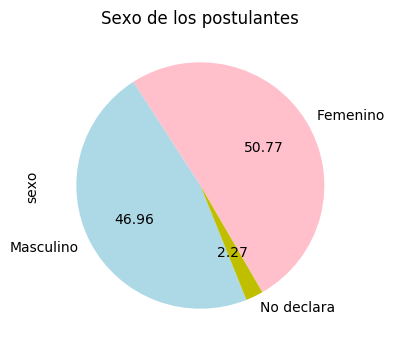

In [12]:
sex_colors=['pink','lightblue','y']
sexo = postulantes_sexo_y_edad['sexo'].value_counts()
sexo.plot.pie(fontsize=10, figsize=(4, 4), startangle=300, autopct='%.2f',
              title='Sexo de los postulantes', colors=sex_colors);

#### Edades de los postulantes

In [18]:
def calcular_edad(fecha_nacimiento):
    hoy = datetime.date.today()
    return hoy.year - fecha_nacimiento.year - ((hoy.month, hoy.day) < (fecha_nacimiento.month, fecha_nacimiento.day))

postulantes_sexo_y_edad['edad'] = postulantes_sexo_y_edad['fechanacimiento'].apply(lambda x: calcular_edad(x))
postulantes_sexo_y_edad.head()

,idpostulante,fechanacimiento,sexo,edad
0,NM5M,1970-12-03,Femenino,47.0
1,5awk,1962-12-04,Femenino,55.0
2,ZaO5,1978-08-10,Femenino,39.0
3,NdJl,1969-05-09,Masculino,48.0
4,eo2p,1981-02-16,Masculino,37.0


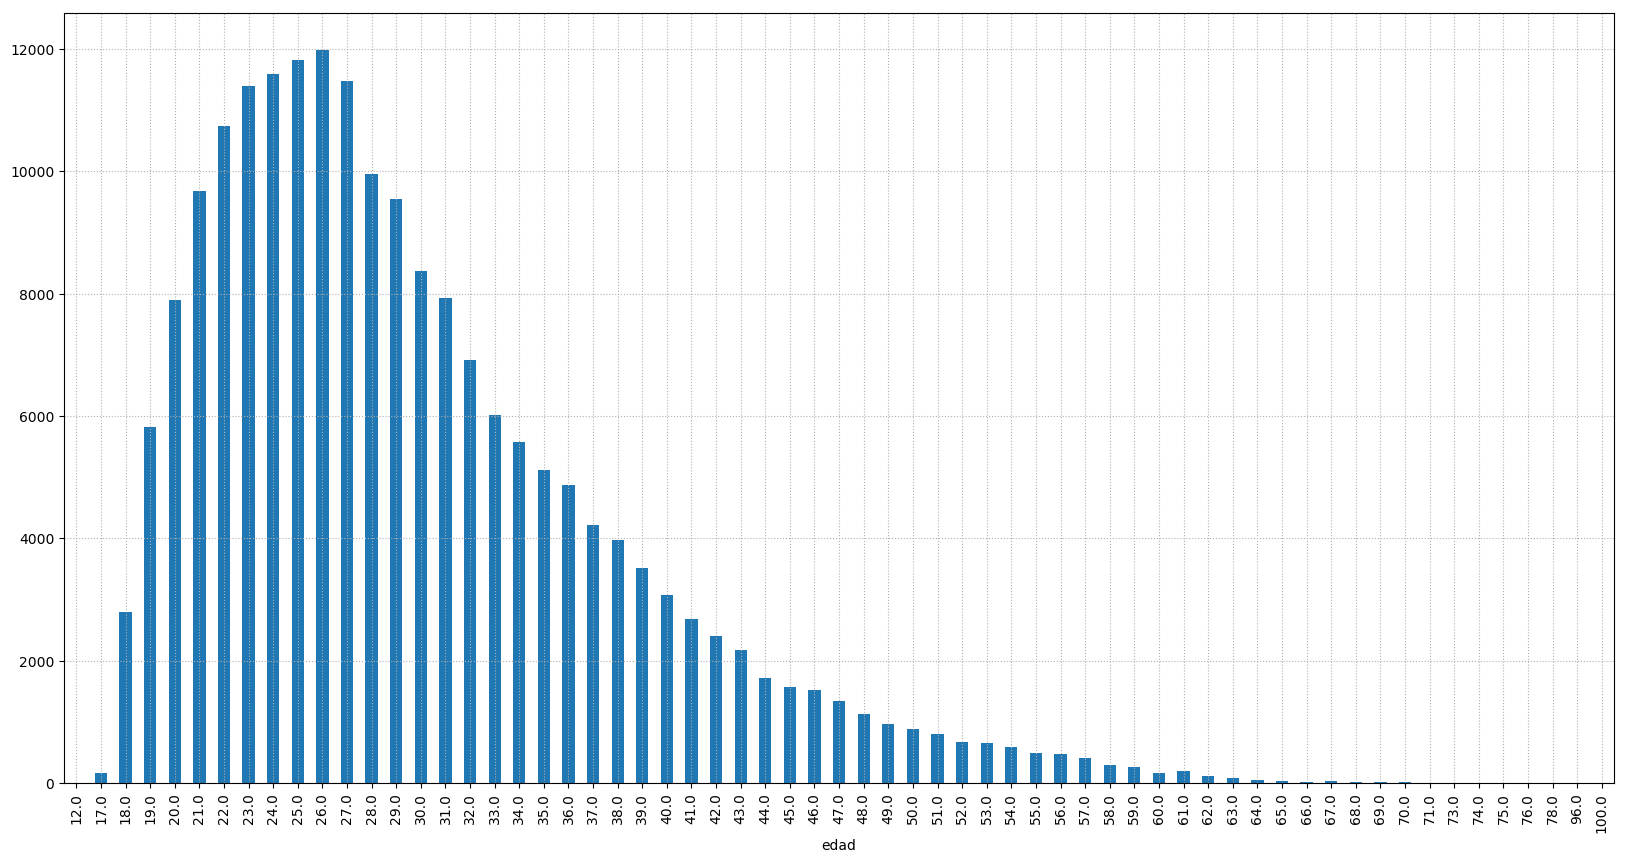

In [46]:
plt = postulantes_sexo_y_edad.loc[postulantes_sexo_y_edad['edad'] <= 100,:].groupby('edad').size().plot(kind='bar')
plt.grid(linestyle='dotted')

Agregamos una nueva columna para categorizar el nivel de estudios alcanzado:

In [19]:
def categorizar_estudios(x):
    if((x is np.nan) | (x == 'Otro')):
        return 0
    if(x == 'Secundario'):
        return 1
    if(x == 'Terciario/Técnico'):
        return 2
    if(x == 'Universitario'):
        return 3
    if((x == 'Posgrado') | (x == 'Master') | (x == 'Doctorado')):
        return 4

postulantes_educacion['nivel_alcanzado'] = postulantes_educacion['nombre']\
    .apply(lambda x: categorizar_estudios(x))
postulantes_educacion.head()

,idpostulante,nombre,estado,nivel_alcanzado
0,NdJl,Posgrado,En Curso,4
1,8BkL,Universitario,En Curso,3
2,1d2B,Universitario,En Curso,3
3,NPBx,Universitario,En Curso,3
4,NPBx,Master,En Curso,4


Unimos ambos *data frames* de los postulantes:

In [20]:
postulantes = pd.merge(postulantes_sexo_y_edad, postulantes_educacion, on='idpostulante', how='outer')
postulantes.head()

,idpostulante,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado
0,NM5M,1970-12-03,Femenino,47.0,Secundario,Graduado,1.0
1,5awk,1962-12-04,Femenino,55.0,Universitario,Graduado,3.0
2,5awk,1962-12-04,Femenino,55.0,Terciario/Técnico,Graduado,2.0
3,ZaO5,1978-08-10,Femenino,39.0,Terciario/Técnico,Graduado,2.0
4,ZaO5,1978-08-10,Femenino,39.0,Universitario,Abandonado,3.0


In [21]:
postulantes = postulantes.sort_values('nivel_alcanzado', ascending=False).drop_duplicates('idpostulante')
postulantes.count()

idpostulante       200888
fechanacimiento    196131
sexo               200888
edad               196131
nombre             188752
estado             188752
nivel_alcanzado    188752
dtype: int64

In [22]:
nivel_sexo = postulantes.groupby(['sexo','nivel_alcanzado']).count().reset_index()\
    .drop(['fechanacimiento','nombre','estado'],axis=1)\
    .pivot(index='nivel_alcanzado', columns='sexo', values='idpostulante')
nivel_sexo

sexo,Femenino,Masculino,No declara
nivel_alcanzado,,,
0.0,579,731,28
1.0,28060,33162,1189
2.0,15593,11480,356
3.0,48298,38455,1085
4.0,4473,5188,75


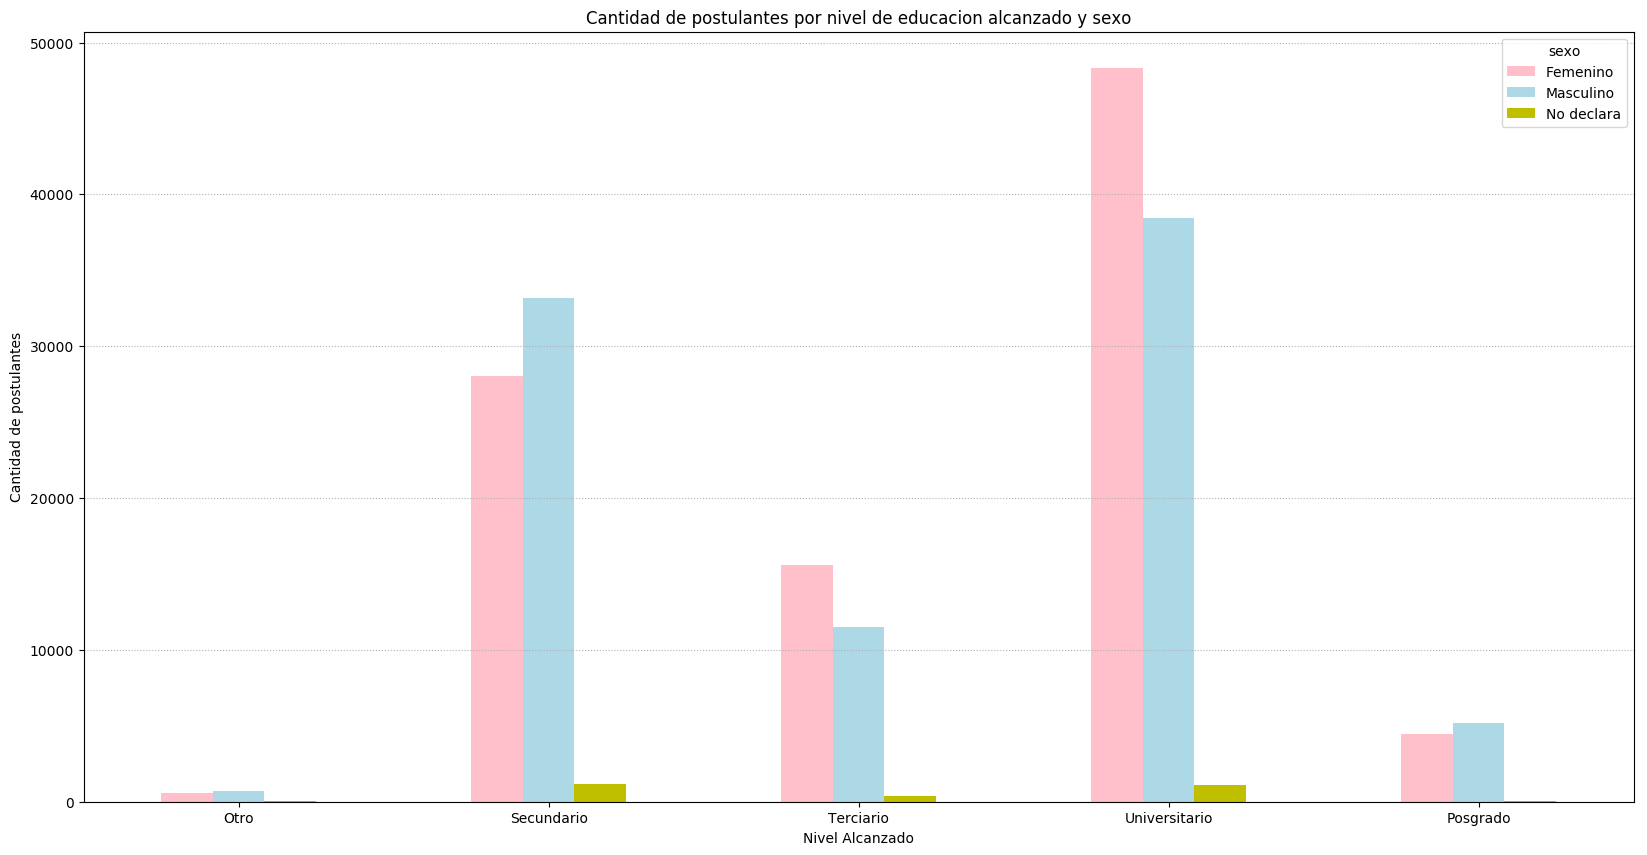

In [18]:
plt = nivel_sexo.plot(kind='bar',rot=0,color=sex_colors)
plt.set_xlabel('Nivel Alcanzado')
plt.set_ylabel('Cantidad de postulantes')
plt.set_title('Cantidad de postulantes por nivel de educacion alcanzado y sexo')
plt.set_xticklabels( ('Otro', 'Secundario','Terciario','Universitario','Posgrado'))
plt.grid(linestyle='dotted')
plt.xaxis.grid(False);

In [ ]:
plt = nivel_sexo.plot(kind='bar',rot=0,color=sex_colors)
plt.set_xlabel('Nivel Alcanzado')
plt.set_ylabel('Cantidad de postulantes')
plt.set_title('Cantidad de postulantes por nivel de educacion alcanzado y sexo')
plt.set_xticklabels( ('Otro', 'Secundario','Terciario','Universitario','Posgrado'))
plt.grid(linestyle='dotted')
plt.xaxis.grid(False);

## 3. Análisis de los avisos

### Zonas de CABA con más avisos

### Áreas de trabajo más populares por zona

### Ver si hay correlación con ubicación de estaciones de subte, hospitales y facultades

### Análisis de las descripciones:
    Rango de edad, nacionalidad, proactividad, estudiantes, residencia en la zona, Office, horarios rotativos/flexibles, PYME

## 4. Análisis de las vistas y postulaciones

### Cantidad de postulaciones por día

### Rangos horarios con más vistas

### Rangos horarios con más postulaciones

### Correlación entre edad, tipo de trabajo, y horario de vistas y de postulaciones

### Cantidad de vistas de los postulantes antes de cada postulación

### Variedad de las áreas de trabajo a las que se postulan

In [93]:
avisos_detalle.loc[(avisos_detalle.descripcion.str.contains('hombre') |\
                    avisos_detalle.descripcion.str.contains('masculino')),:]\
                    .groupby('nombre_area').count().sort_values('idaviso', ascending=False).head()

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,denominacion_empresa
nombre_area,,,,,,,,,,
Producción,64,64,64,64,64,0,7,64,64,64
Comercial,53,53,53,53,53,0,3,53,53,53
Ventas,47,47,47,47,47,0,5,47,47,46
Seguridad,28,28,28,28,28,0,0,28,28,28
Gastronomia,23,23,23,23,23,0,0,23,23,23


In [112]:
avisos_detalle.loc[(avisos_detalle.descripcion.str.contains('inglés') |\
                    avisos_detalle.descripcion.str.contains('ingles')),:]\
                    .groupby('tipo_de_trabajo').count().sort_values('idaviso', ascending=False).head(10)

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,nivel_laboral,nombre_area,denominacion_empresa
tipo_de_trabajo,,,,,,,,,,
Full-time,1200,1200,1200,1200,1200,6,51,1200,1200,1200
Part-time,24,24,24,24,24,0,2,24,24,24
Pasantia,15,15,15,15,15,0,3,15,15,15
Temporario,4,4,4,4,4,2,1,4,4,4
Por Contrato,2,2,2,2,2,0,0,2,2,2
Por Horas,1,1,1,1,1,0,0,1,1,1


In [78]:
postulantes_educacion.groupby('nombre').count()

,idpostulante,estado
nombre,,
Doctorado,214,214
Master,3598,3598
Otro,24748,24748
Posgrado,7387,7387
Secundario,110256,110256
Terciario/Técnico,47733,47733
Universitario,104295,104295


In [64]:
#[int(s) for s in avisos_detalle.groupby('mapacalle').str.split() if s.isdigit()]
def saraza(x):
    l = []
    for s in x.split():
        if s.isdigit():
          l.append(s)
    if len(l):
        return True
    return False
df3 = avisos_detalle.groupby(['mapacalle','nombre_zona']).count().reset_index()
df3['mapacalle_nums'] = df3.mapacalle.apply(lambda x: saraza(x))
df3

,mapacalle,nombre_zona,idaviso,idpais,titulo,descripcion,ciudad,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,mapacalle_nums
0,AMEGHINO 653,Capital Federal,1,1,1,1,0,1,1,1,1,True
1,AV. Hipolito Yrigoyen 13000,Capital Federal,1,1,1,1,0,1,1,1,1,True
2,Av. Victorica 598,Capital Federal,1,1,1,1,0,1,1,1,1,True
3,Luis Tejeda 4050,Capital Federal,1,1,1,1,0,1,1,1,1,True
4,12 de Octubre 3783,Capital Federal,1,1,1,1,0,1,1,1,1,True
5,24 de septiembre 6,Capital Federal,1,1,1,1,0,1,1,1,1,True
6,25 de Mayo 2092,Capital Federal,2,2,2,2,0,2,2,2,2,True
7,25 de Mayo 457 7º piso,Capital Federal,6,6,6,6,0,6,6,6,6,True
8,9 de Julio 346,Capital Federal,3,3,3,3,0,3,3,3,3,True
9,ALEM 116,Capital Federal,1,1,1,1,0,1,1,1,1,True


In [65]:
df3.nombre_zona.value_counts()

Capital Federal    487
GBA Oeste          1  
Name: nombre_zona, dtype: int64

In [59]:
df4 = df3[df3.mapacalle_nums == True]

In [60]:
df4

,mapacalle,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,mapacalle_nums
0,AMEGHINO 653,1,1,1,1,1,0,1,1,1,1,True
1,AV. Hipolito Yrigoyen 13000,1,1,1,1,1,0,1,1,1,1,True
2,Av. Victorica 598,1,1,1,1,1,0,1,1,1,1,True
3,Luis Tejeda 4050,1,1,1,1,1,0,1,1,1,1,True
4,12 de Octubre 3783,1,1,1,1,1,0,1,1,1,1,True
5,24 de septiembre 6,1,1,1,1,1,0,1,1,1,1,True
6,25 de Mayo 2092,2,2,2,2,2,0,2,2,2,2,True
7,25 de Mayo 457 7º piso,6,6,6,6,6,0,6,6,6,6,True
8,9 de Julio 346,3,3,3,3,3,0,3,3,3,3,True
9,ALEM 116,1,1,1,1,1,0,1,1,1,1,True


In [61]:
avisos_detalle.nombre_zona.value_counts()

Gran Buenos Aires              12654
Capital Federal                876  
GBA Oeste                      2    
Buenos Aires (fuera de GBA)    2    
Name: nombre_zona, dtype: int64

In [66]:
avisos_detalle.count()

idaviso                 13534
idpais                  13534
titulo                  13534
descripcion             13534
nombre_zona             13534
ciudad                  47   
mapacalle               872  
tipo_de_trabajo         13534
nivel_laboral           13534
nombre_area             13534
denominacion_empresa    13529
dtype: int64

In [47]:
vistas.rename(index=str, columns={"idAviso": "idaviso"}, inplace=True)
vis_avi = pd.merge(vistas, avisos_detalle, on='idaviso', how='inner')
vis_avi = pd.merge(vis_avi,postulantes,on = 'idpostulante',how='inner')

In [73]:
#Hay más vistas hacia la tarde/noche que a la mañana
vis_avi['hora'] = vis_avi.timestamp.dt.hour
vis_avi['edad'] = vis_avi.fechanacimiento.dt.year
vis_avi.groupby('hora').size().to_frame('total').sort_values('total', ascending=False)

,total
hora,
14,66168
15,63737
13,60972
19,59214
20,58042
18,56568
16,56415
17,54704
21,53928


In [76]:
vis_avi.groupby('edad').size().to_frame('total').sort_values('total', ascending=False)

,total
edad,
1993.0,56277
1992.0,55796
1994.0,55477
1991.0,54748
1990.0,53676
1995.0,51278
1996.0,49115
1989.0,48183
1988.0,44578
